In [1]:
import sys
sys.path.append("/opt/SEP/lib/python3.8/")
sys.path.append("/home/users/arustam/cuWEM/operator/lib/python/")
sys.path.append("/home/users/arustam/cuWEM/propagator/lib/python/")

In [2]:
%load_ext autoreload
%autoreload 2
import SepVector
import CudaOperator
import CudaWEM
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt


/usr/local/lib/python3.8/dist-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/lib/python3.8/dist-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/usr/local/lib/python3.8/dist-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/lib/python3.8/dist-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


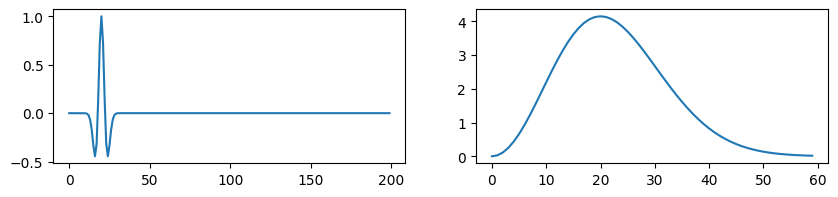

In [3]:
def ricker_wavelet(frequency, Nt, dt, t0=0):
    t = np.linspace(0, (Nt-1)*dt, Nt)
    t_shifted = t - t0
    ricker = (1 - 2 * (np.pi ** 2) * (frequency ** 2) * (t_shifted ** 2)) * np.exp(-(np.pi ** 2) * (frequency ** 2) * (t_shifted ** 2))
    return ricker

# Parameters
frequency = 10  # Ricker wavelet central frequency
Nt = 200    # Length of the wavelet in seconds
dt = 0.01      # Time sampling interval
t0 = 0.2

# Generate Ricker wavelet
wavelet = ricker_wavelet(frequency, Nt, dt, t0=t0)
W = np.fft.fft(wavelet)

dw = 1/((Nt-1)*dt) * 2*np.pi
nw = 60
f, a = plt.subplots(1,2, figsize=[10,2])
a[0].plot(wavelet, label='Ricker Wavelet')
a[1].plot(np.abs(W[:nw]), label="Spectrue")

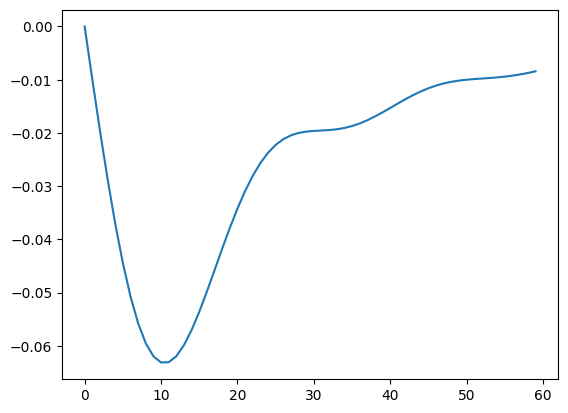

In [4]:
npml_t = 10 
amax = 1e-2

tpml = np.zeros(Nt)
tpml[:npml_t] = np.linspace(0, amax, npml_t)[::-1]
tpml[-npml_t:] = -tpml[:npml_t][::-1]

wpml = np.fft.fft(tpml)[:nw]

plt.plot(np.imag(wpml))

In [5]:
nx = 200
ny = 200
nz = 10
nsrc = 10

ns = [nx,ny,nw,nz]
ds = [0.01, 0.01, dw, .01]
os = [0,   0,   0.,  0]
slow = SepVector.getSepVector(ns=ns, ds=ds, os=os, storage='dataComplex')
slow[:,:,:100,:100] = 1/1**2
slow[:,:,:100,100:] = 1/2**2
slow[:,:,100:,:100] = 1/3**2
slow[:,:,100:,100:] = 1/4**2

# add attenuation in the borders
npml = 50
amax = 1e-1
pml = 1j * np.linspace(0,amax,npml) 

slow[:,:,:npml,:] += -pml[::-1, np.newaxis] 
slow[:,:,-npml:,:] += -pml[:, np.newaxis]
slow[:,:,:,:npml] += -pml[::-1]
slow[:,:,:,-npml:] += -pml

In [6]:
# add time pml
# slow[:].imag += wpml[np.newaxis, :, np.newaxis, np.newaxis].imag

In [6]:
nref = 11
ref = CudaWEM.RefSampler(slow, nref)

In [7]:
iz = 0 
arr = np.zeros((nref, nw), dtype=complex)
for iref in range(nref):
    arr[iref,:] = ref.get_ref_slow(iz,iref)

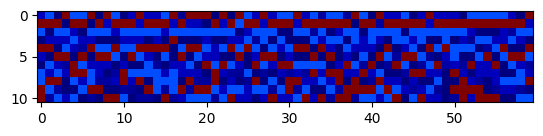

In [8]:
plt.imshow(arr.real, cmap='jet')

In [9]:
labels = ref.get_ref_labels(iz)

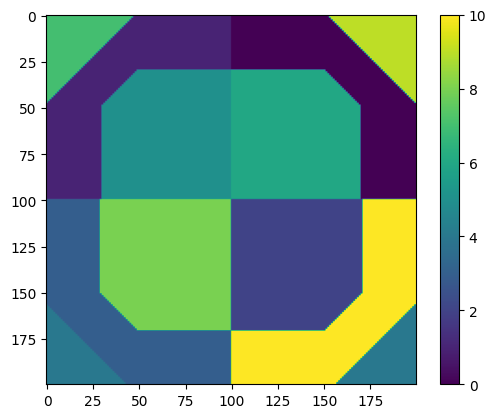

In [10]:
plt.imshow(labels[5,:,:])
plt.colorbar()

In [12]:
arr[:,5]

array([0.25      -0.07189954j, 1.        -0.07189952j,
       0.0625    -0.01017256j, 0.11111399-0.07476058j,
       0.0868065 -0.14285766j, 0.99999994-0.00938527j,
       0.24999999-0.00938527j, 1.        -0.13605489j,
       0.11111264-0.01017256j, 0.25      -0.1360549j ,
       0.0625    -0.07476058j])

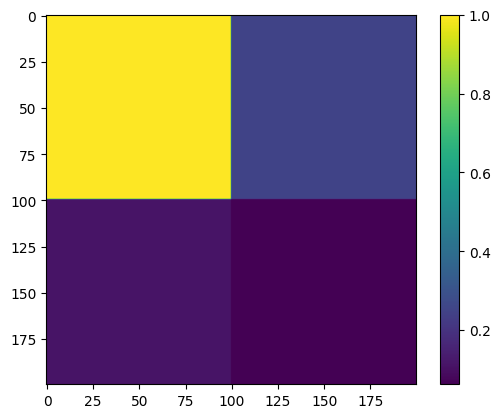

In [11]:
plt.imshow(slow[iz, 0, :, :].real)
plt.colorbar()

In [12]:
ns = [nx,ny,nw,nsrc]
ds = [0.01, 0.01, dw, 1]
os = [0,   0,   0.,   0]

data = SepVector.getSepVector(ns=ns, ds=ds, os=os, storage='dataComplex')

In [13]:
isrc = 5
nd = data[isrc,:,:,:]
nd[:nw,99,99] = W[:nw]

In [14]:
# data[:, :, 250, 250] = W[:]
fft = data.clone()

sig = 3
data[:] = gaussian_filter(data[:], sigma=(1,1,sig,sig))

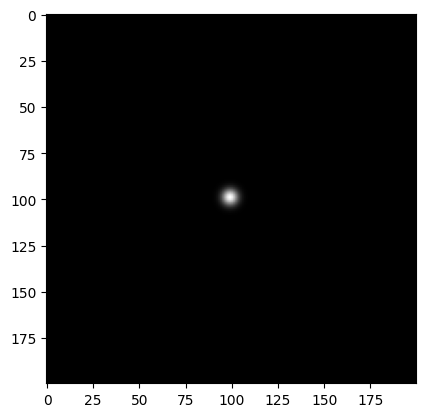

In [15]:

plt.imshow(np.abs(data[isrc,5,:,:]), cmap='gray')

In [16]:
import genericIO
par = {
    "nref" : nref,
    "eps" : 0.0
}
par = genericIO.pythonParams(par)

In [17]:
pspi = CudaWEM.PSPI(data, data, slow, par, ref)
pspi.set_depth(iz)

In [18]:
next_wfld = data.clone()
next_wfld2 = data.clone()

In [19]:
for _ in range(5):
    pspi.forward(False, data, next_wfld)
    data[:] = next_wfld[:]

In [20]:
wfld = np.zeros((Nt, ny, nx), dtype=complex)
wfld[:nw, :, :] = next_wfld[isrc, :, :, :]
wfld[:] = np.fft.ifft(wfld, axis=0).real

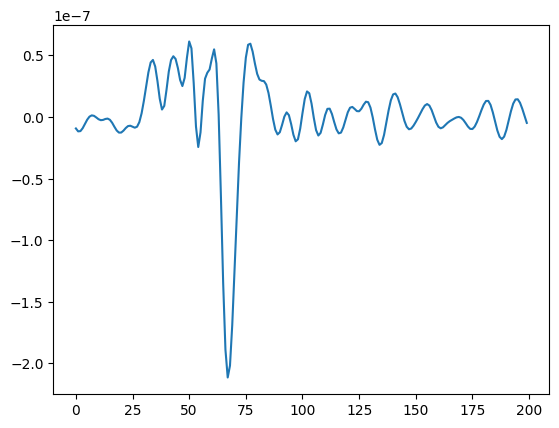

In [21]:
plt.plot(wfld[:,50,50].real)

In [22]:
import holoviews as hv 
hv.extension('matplotlib')
hv.output(widget_location='bottom')

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

In [23]:
snaps = {}
every = 5
pclip = .01
amin = pclip * np.amin(wfld.real)
amax = pclip * np.amax(wfld.real)
# wfld_c = np.clip(wfld.real, amin, amax)

for i in range(0, Nt, every):
    snaps[i] = hv.Image(wfld[i,:,:].real).opts(cmap='gray', clim=(amin, amax))

:HoloMap   [Time]
   :Image   [x,y]   (z)
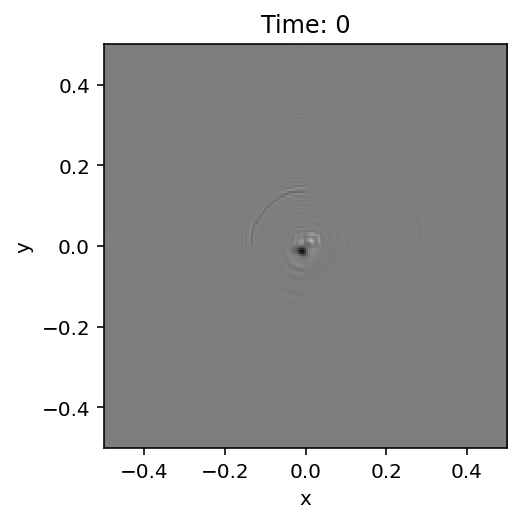
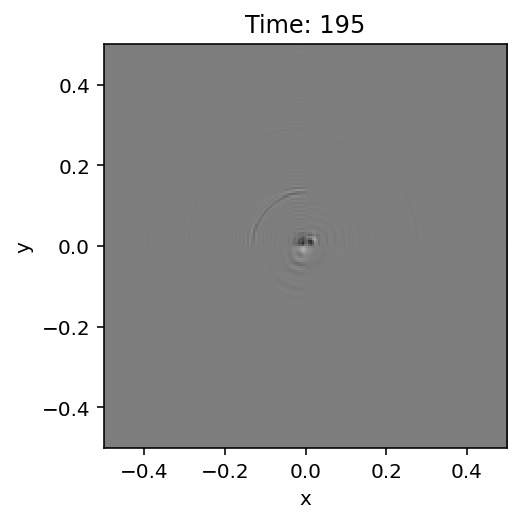
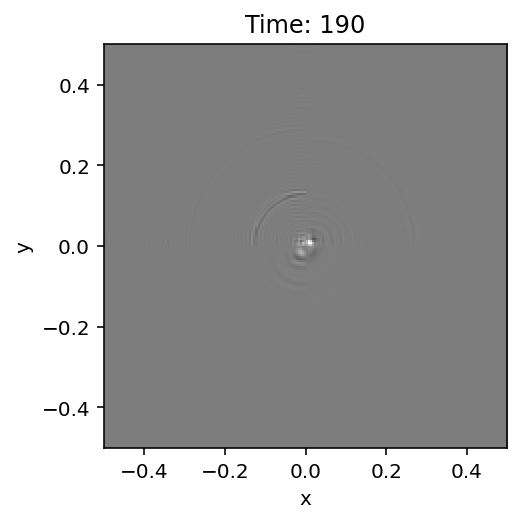
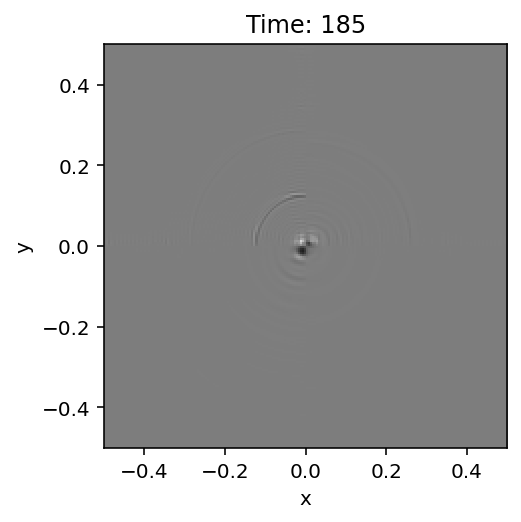
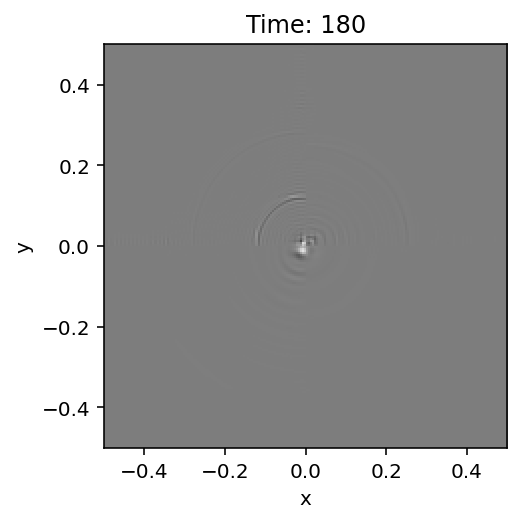
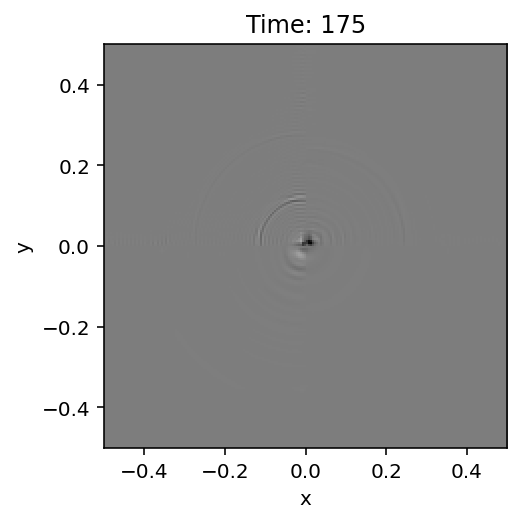
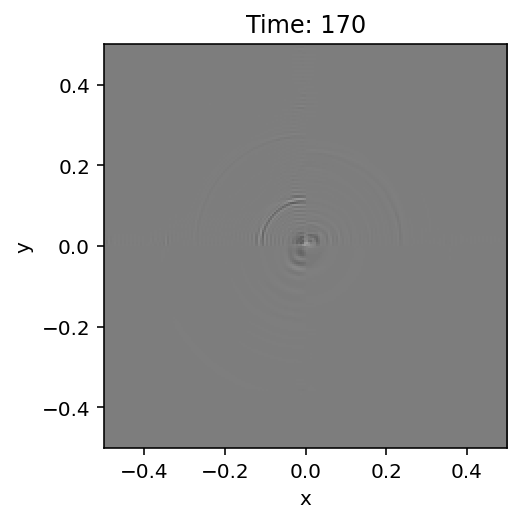
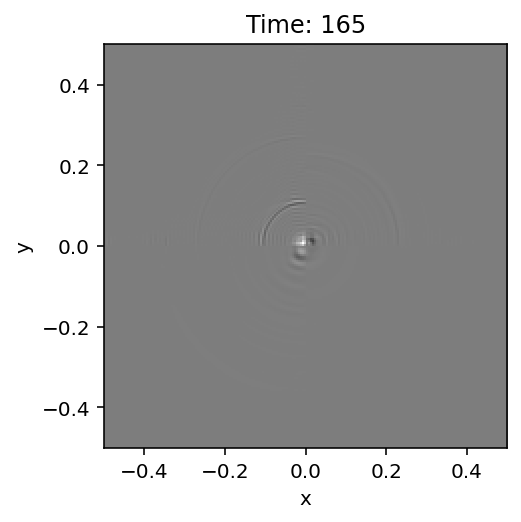
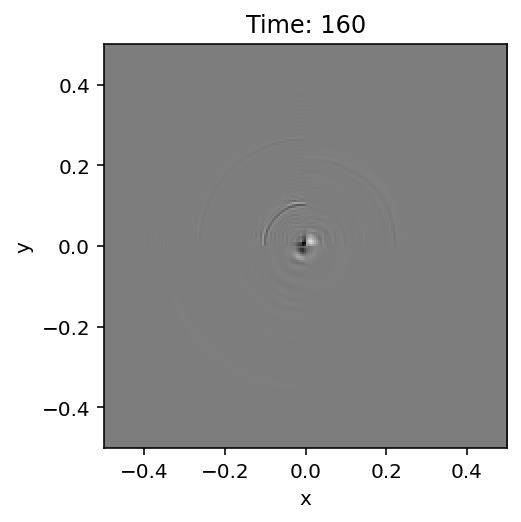
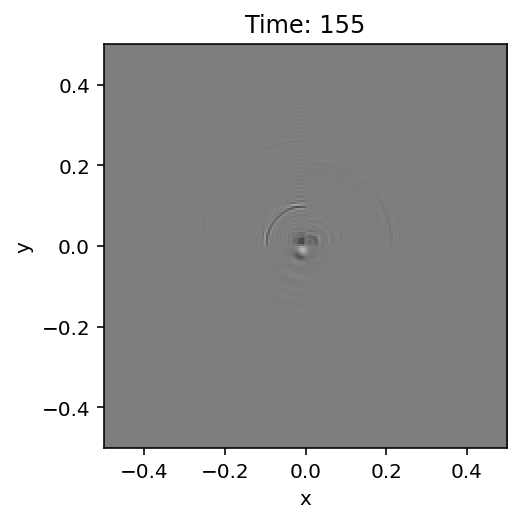
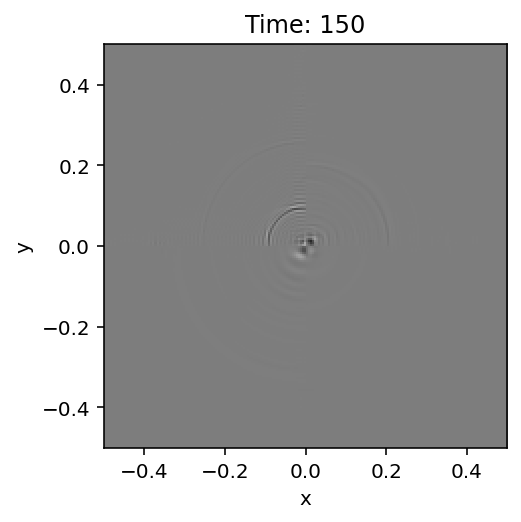
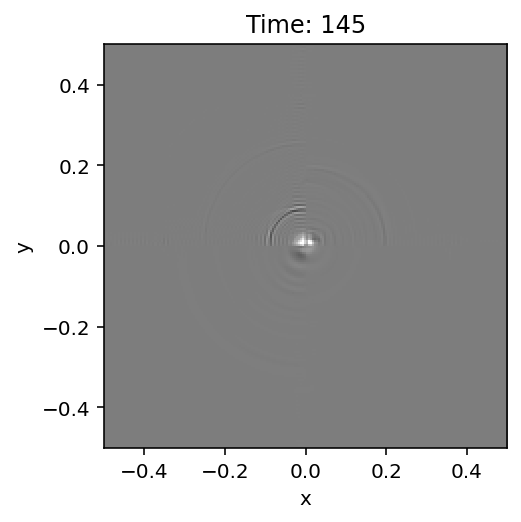
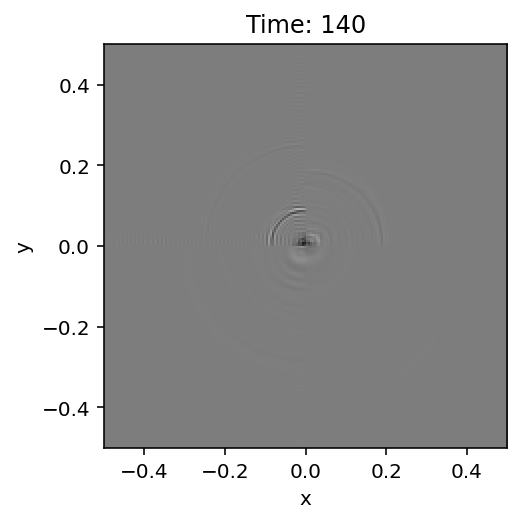
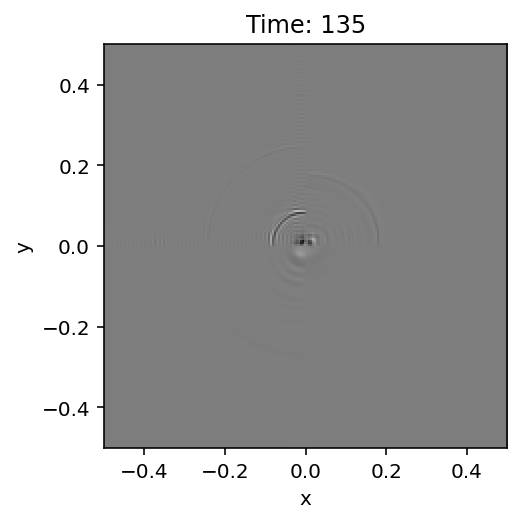
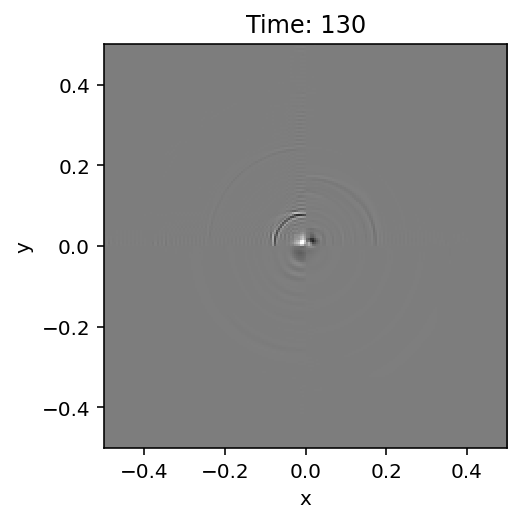
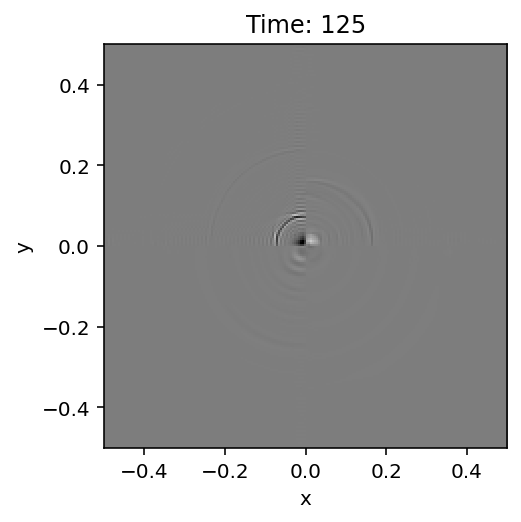
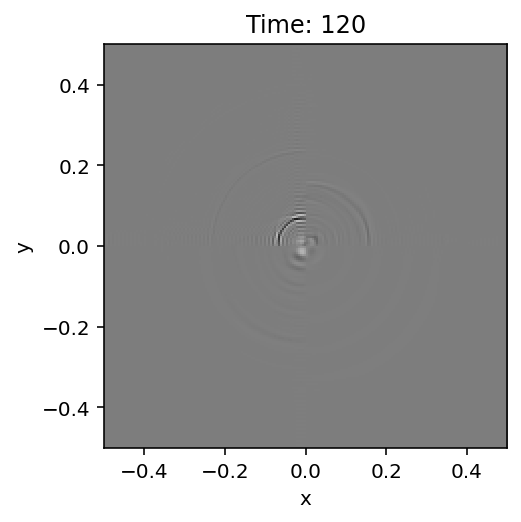
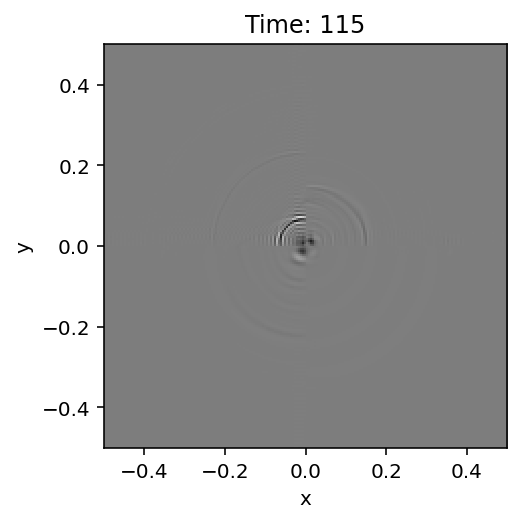
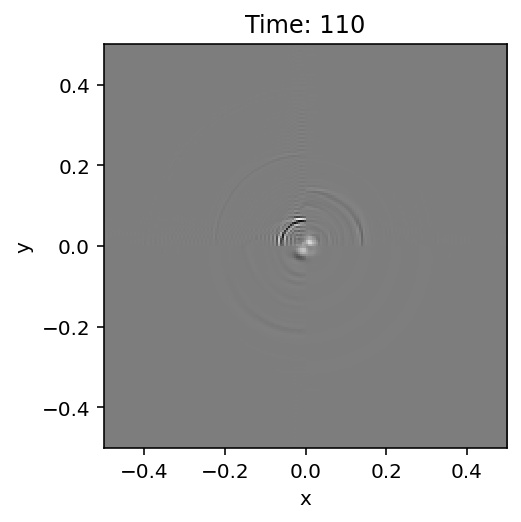
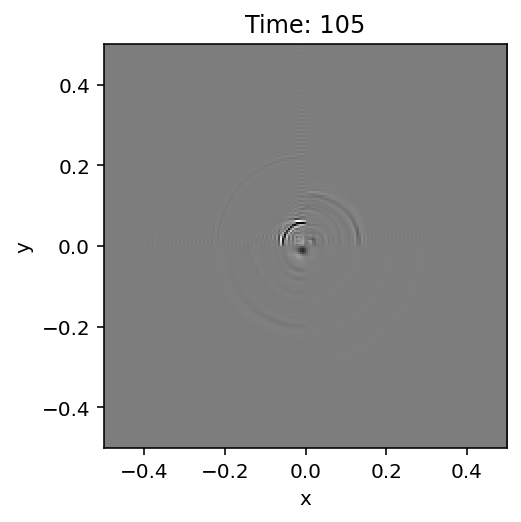
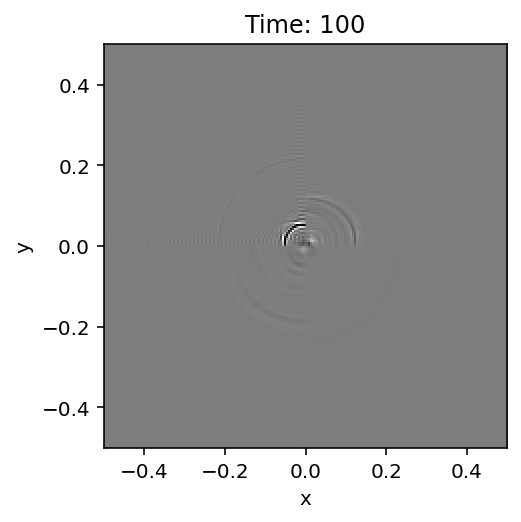
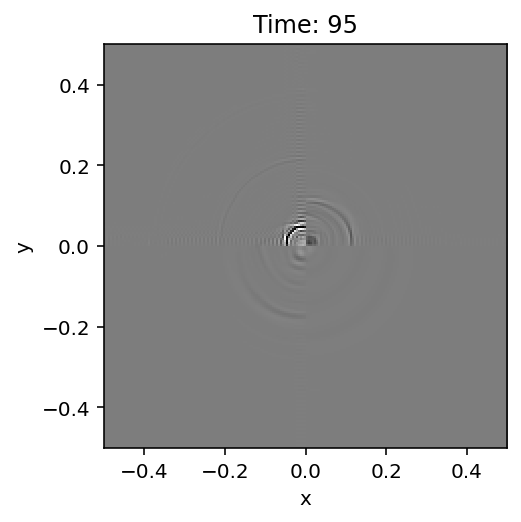
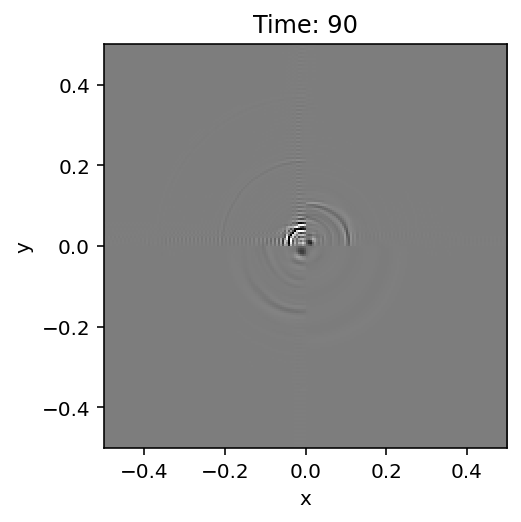
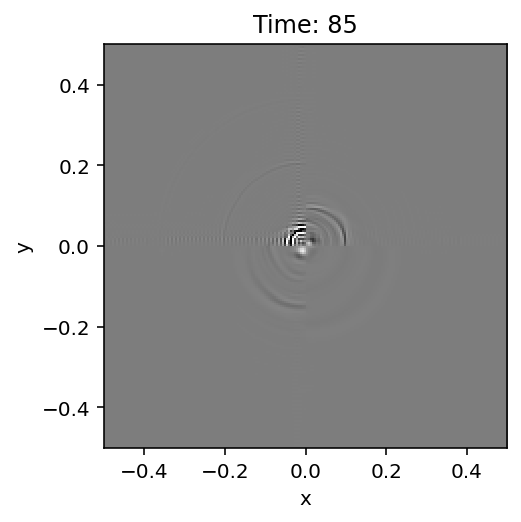
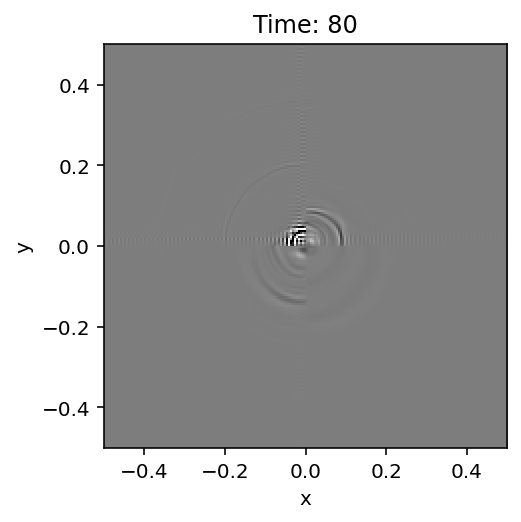
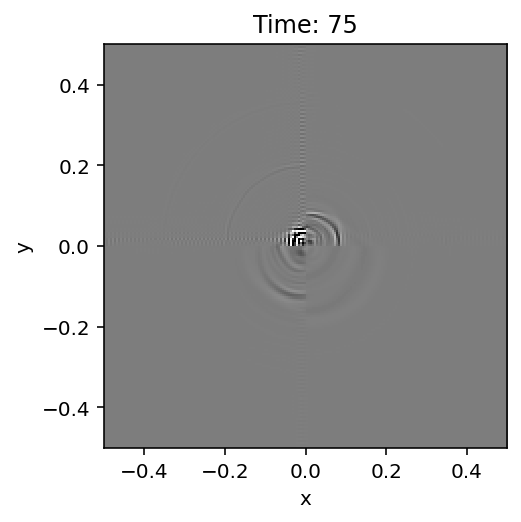
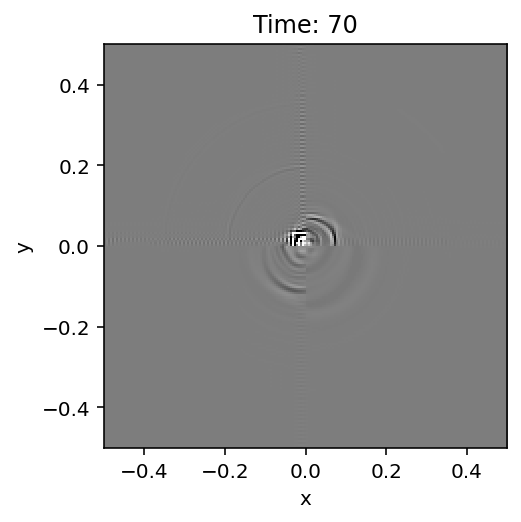
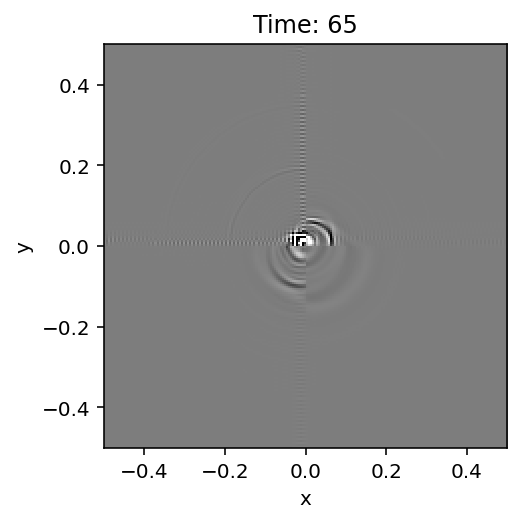
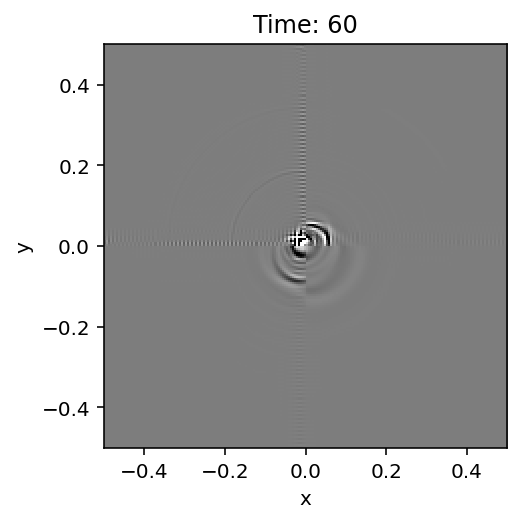
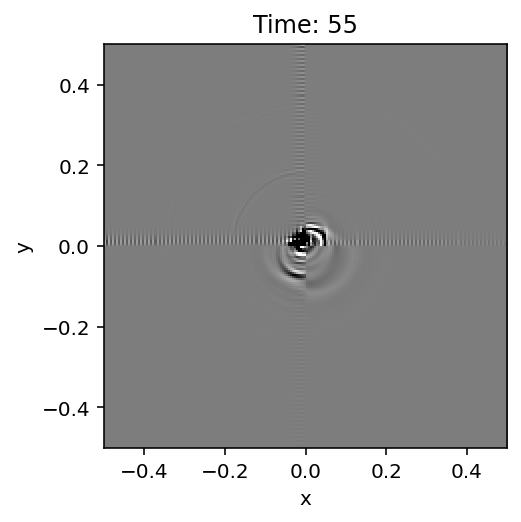
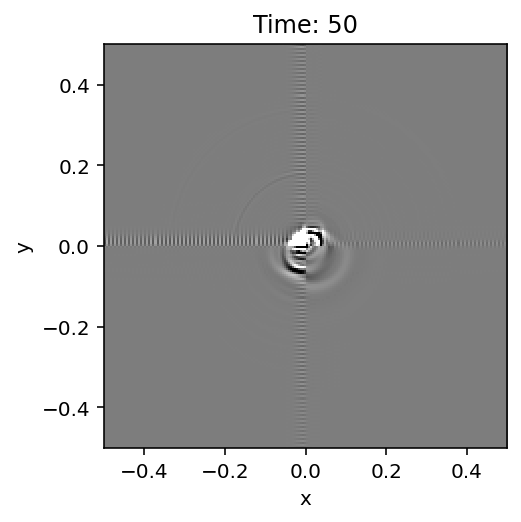
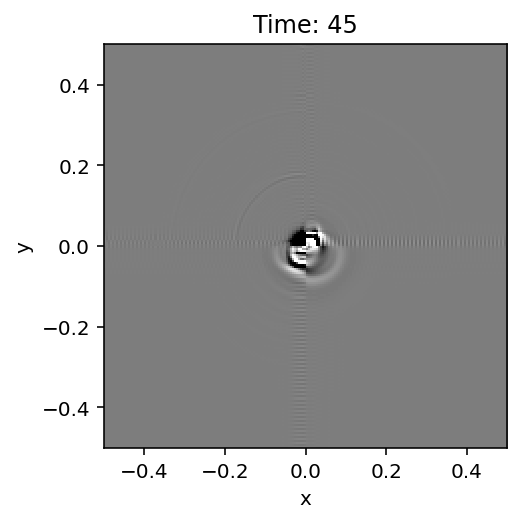
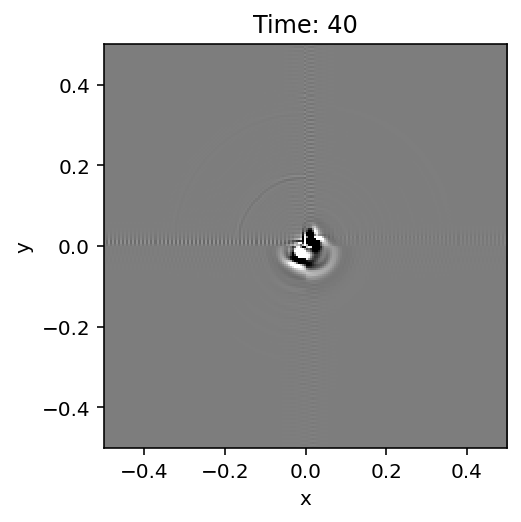
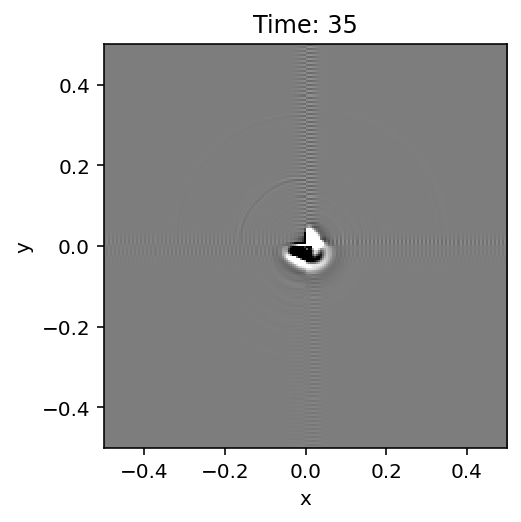
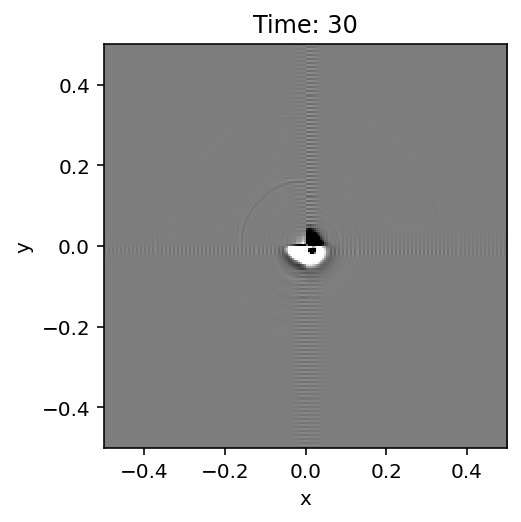
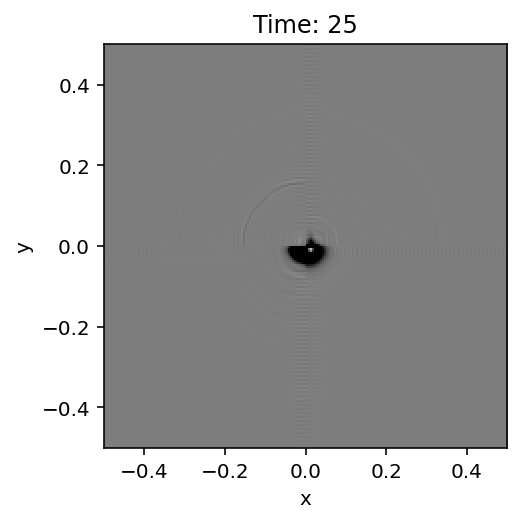
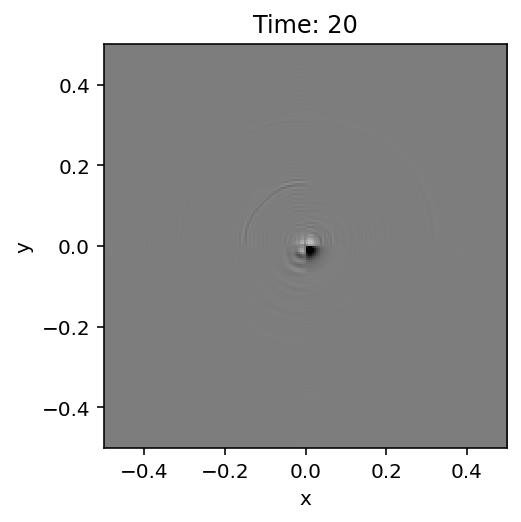
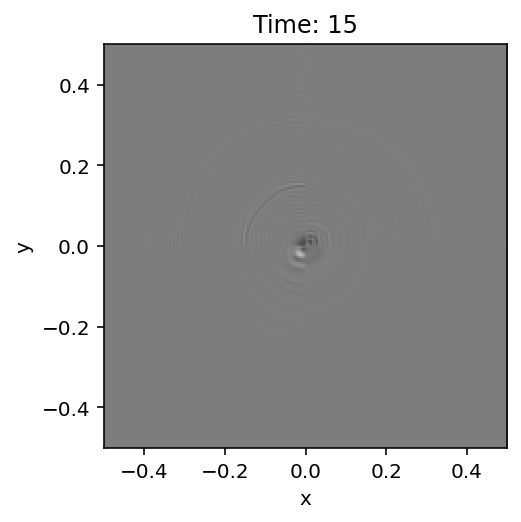
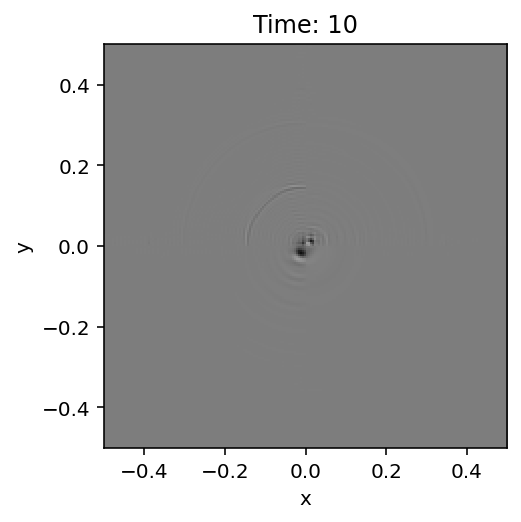
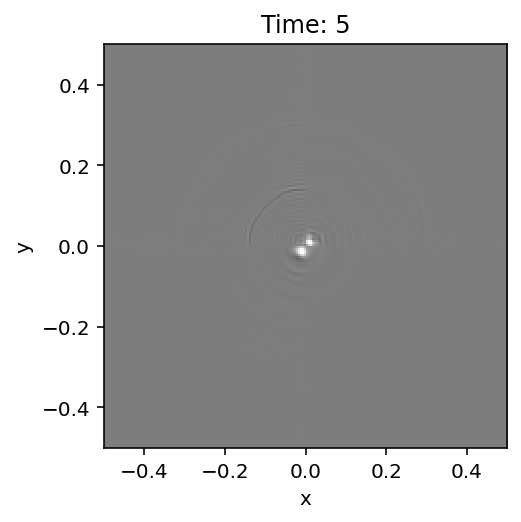
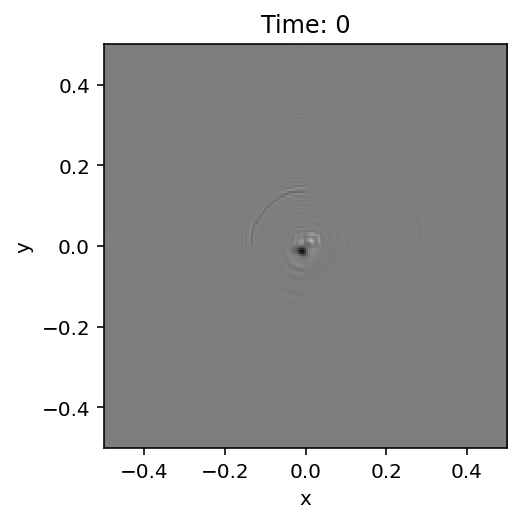

In [24]:
hmap = hv.HoloMap(snaps, kdims='Time')
hmap

In [43]:
iy = 130
for i in range(0, Nt, every):
    snaps[i] = hv.Curve(wfld[i,iy,:].real)

:HoloMap   [Time]
   :Curve   [x]   (y)
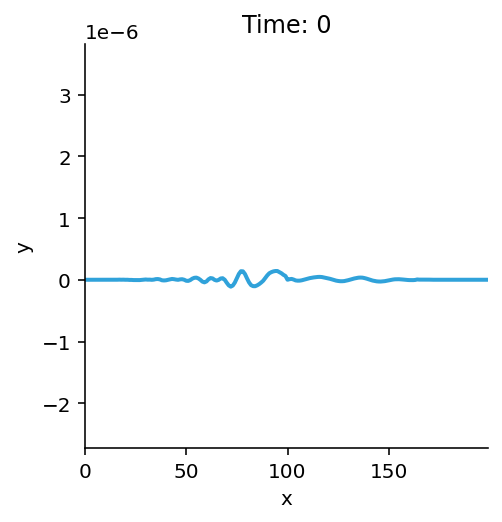
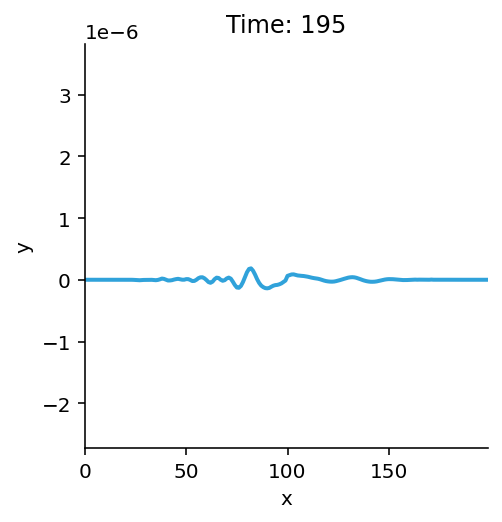
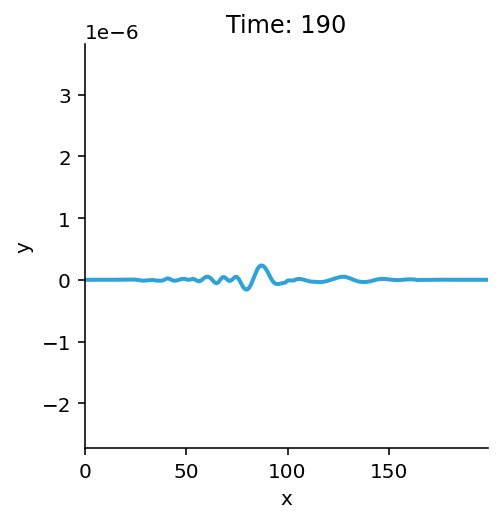
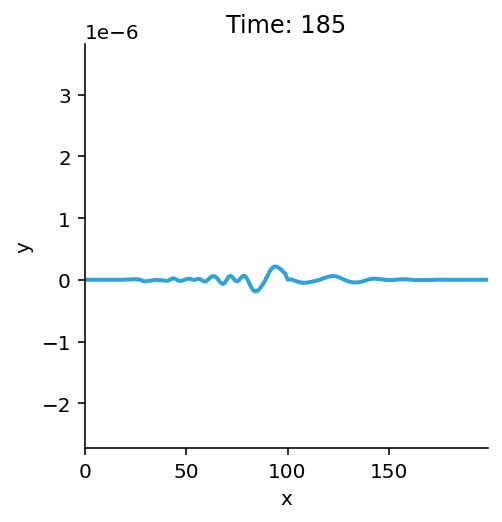
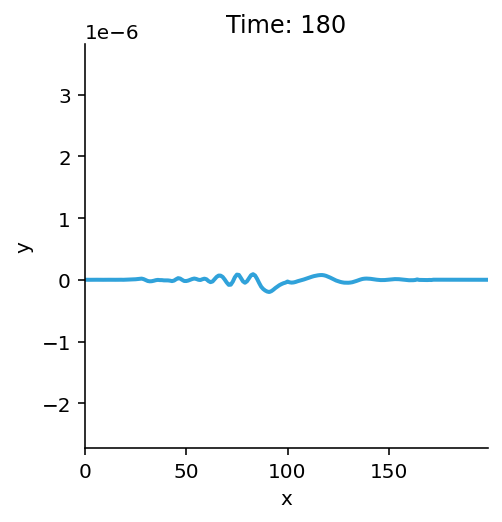
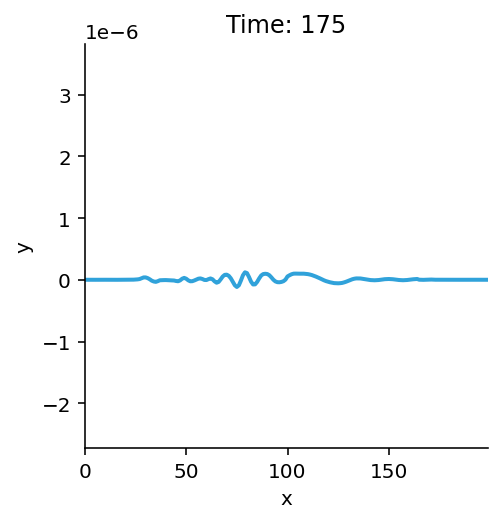
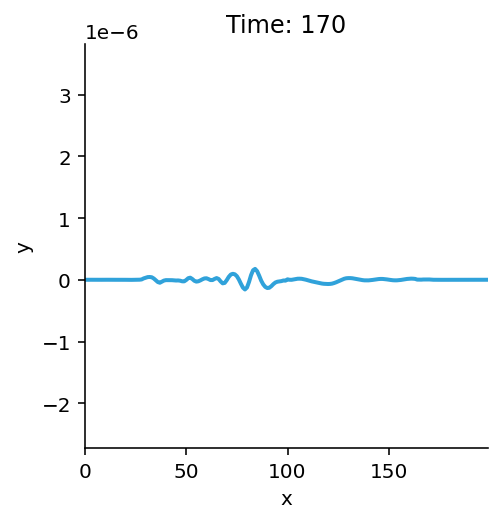
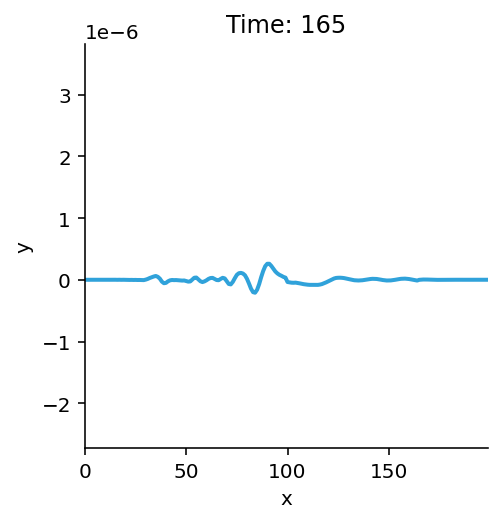
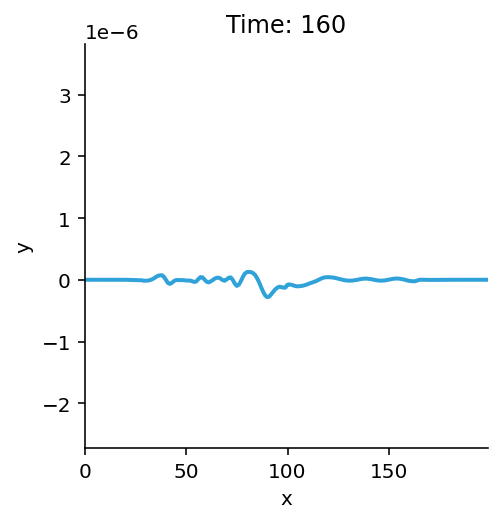
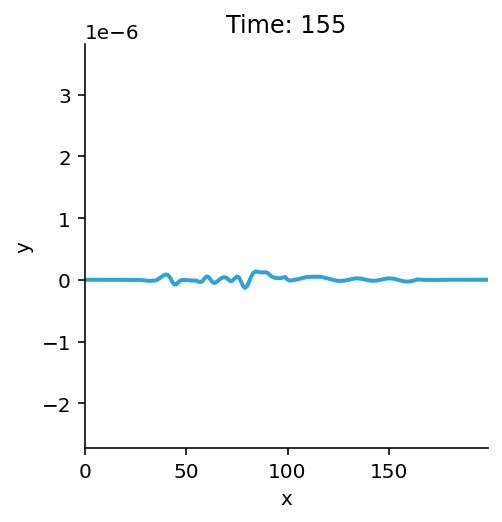
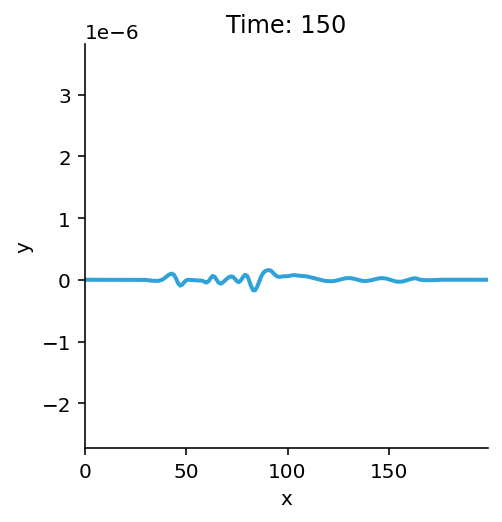
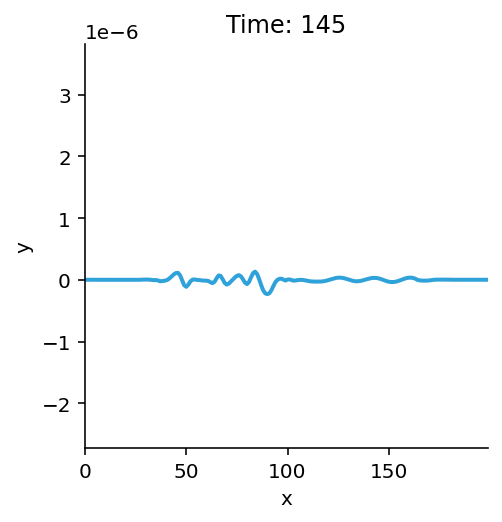
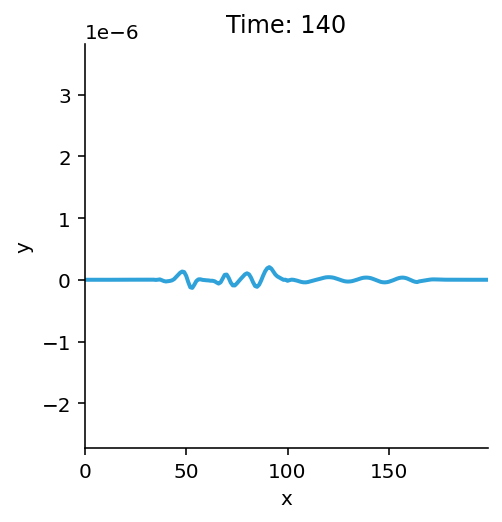
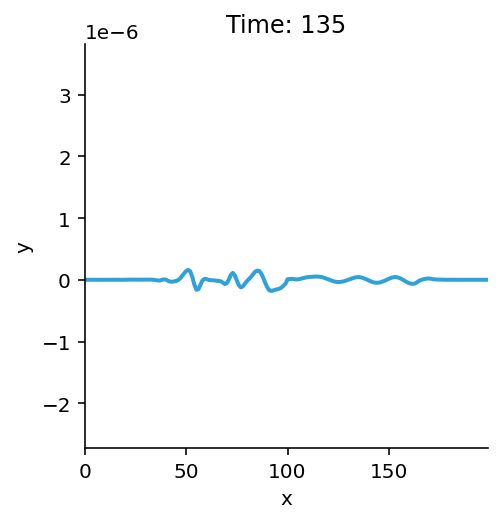
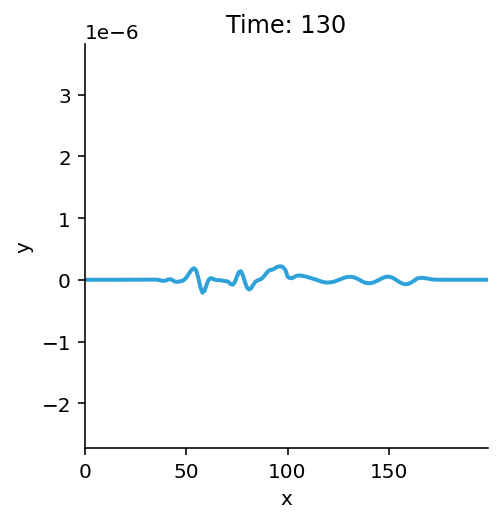
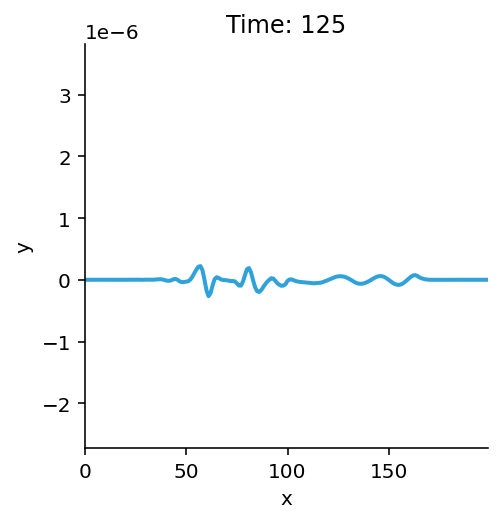
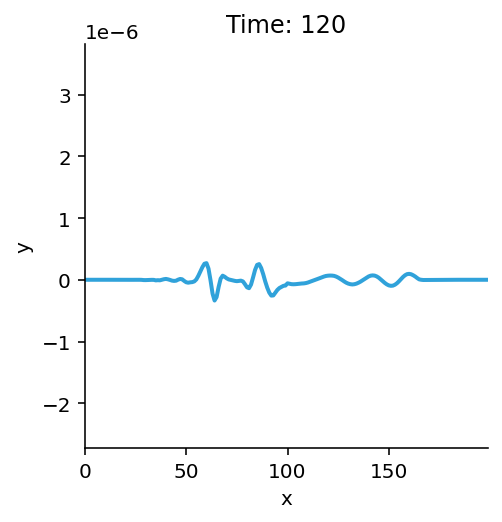
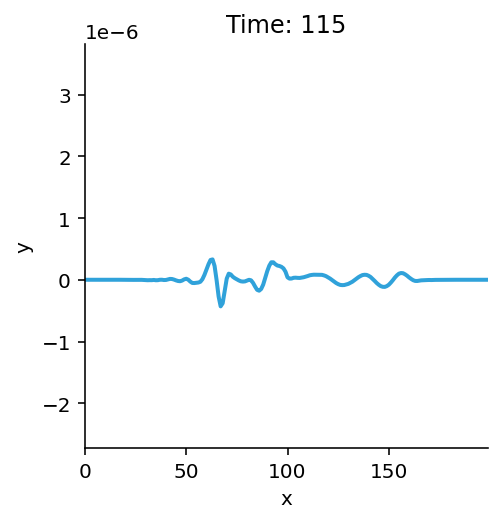
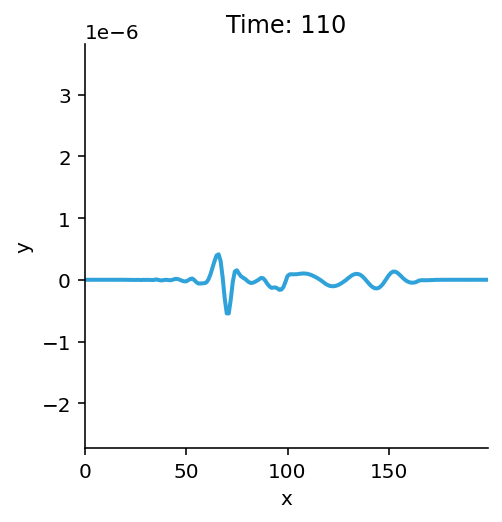
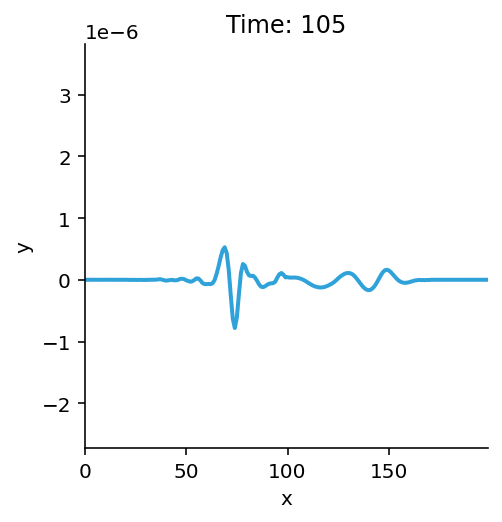
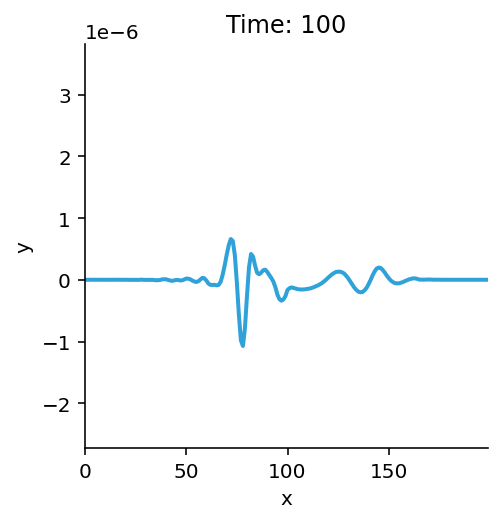
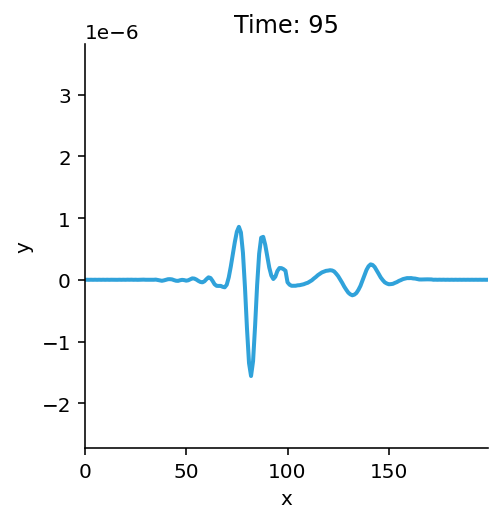
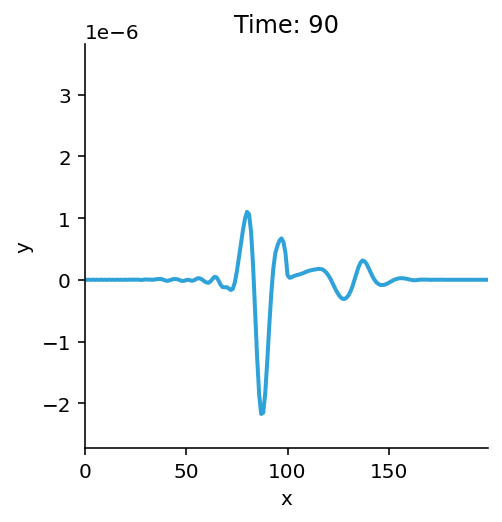
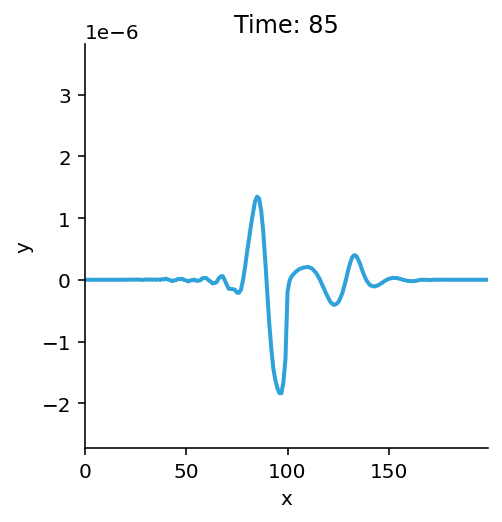
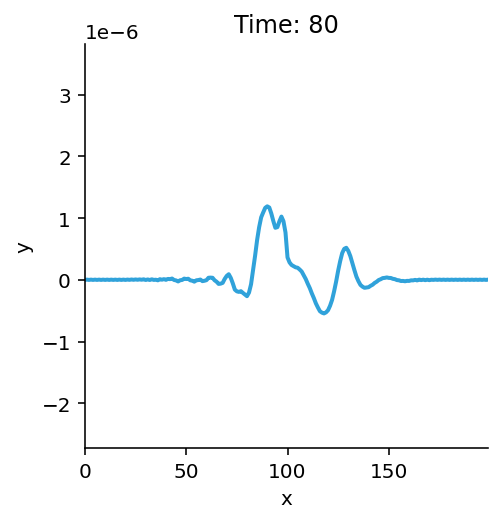
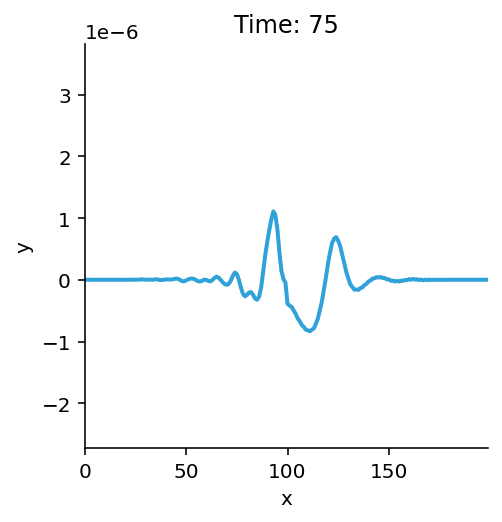
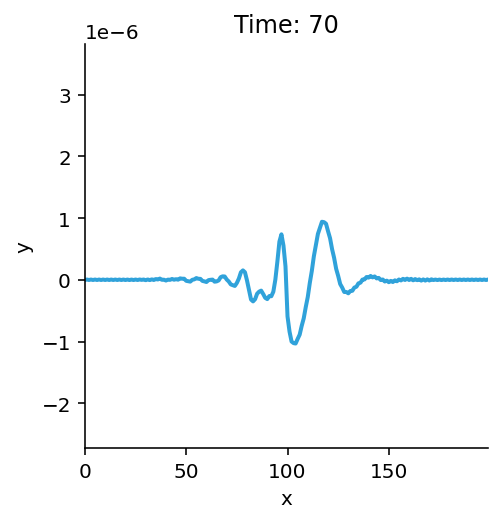
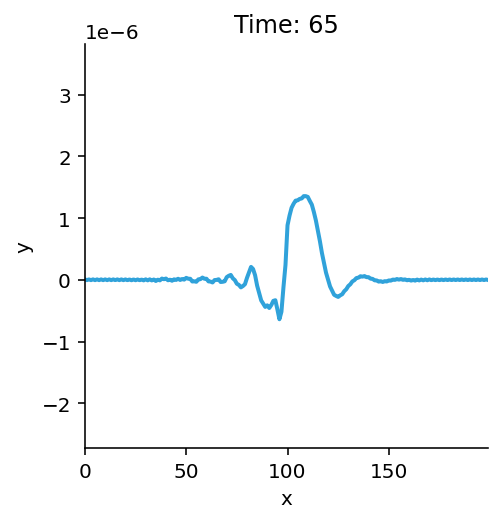
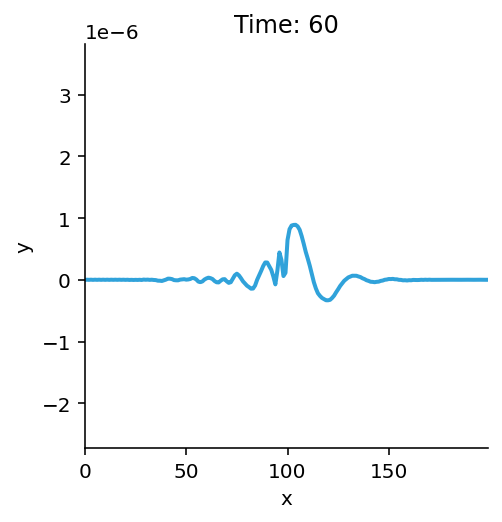
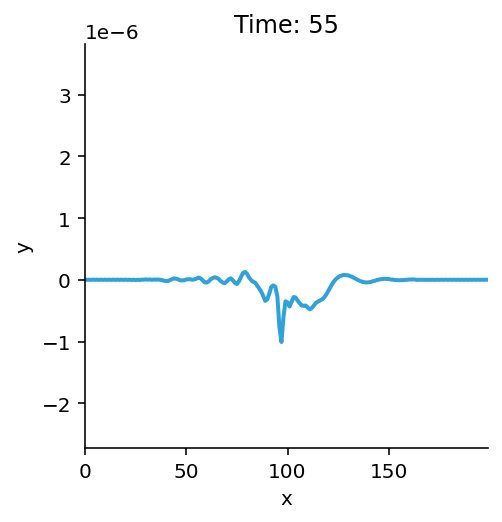
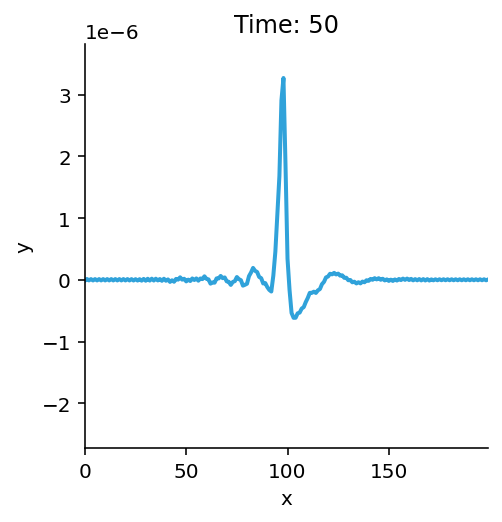
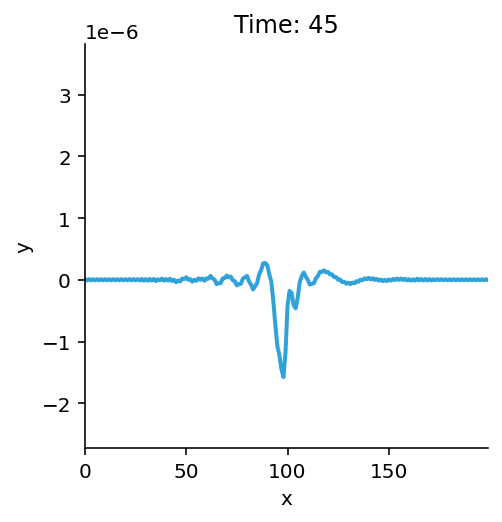
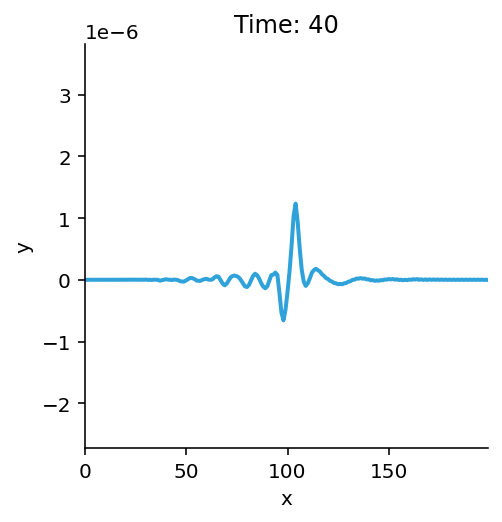
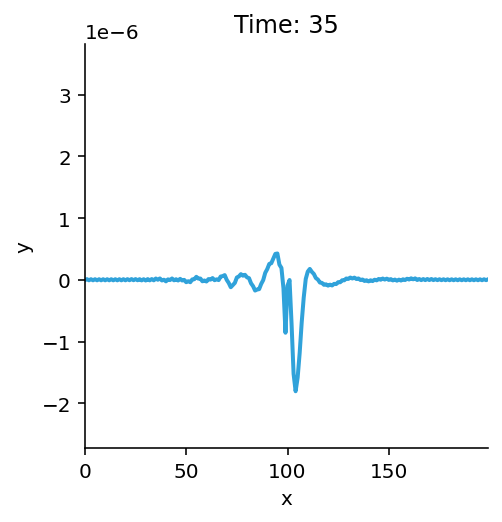
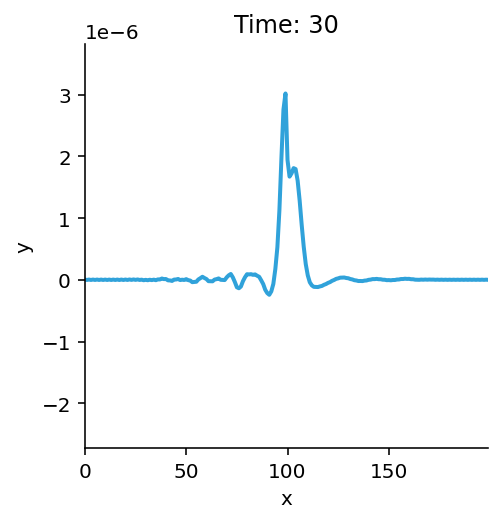
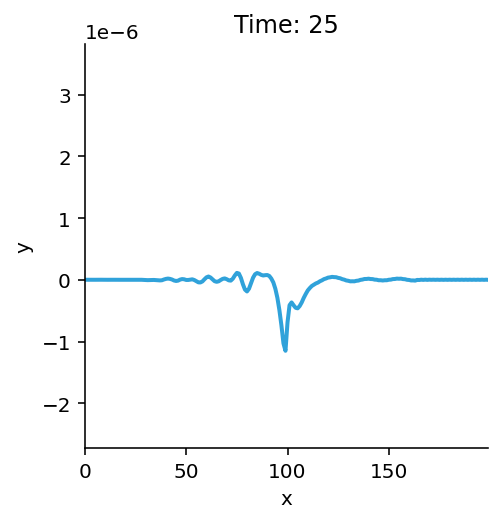
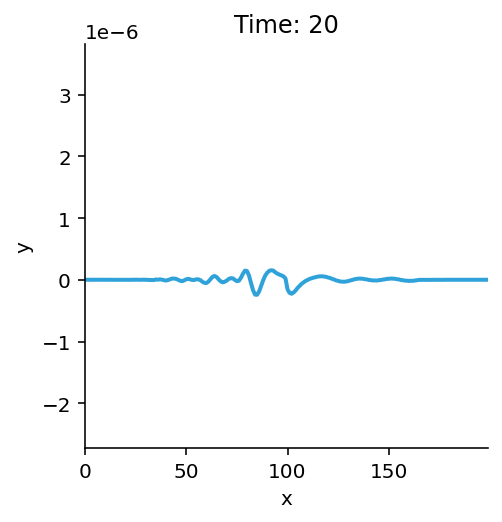
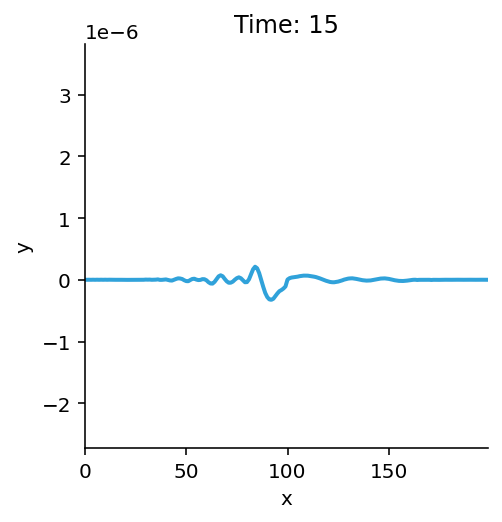
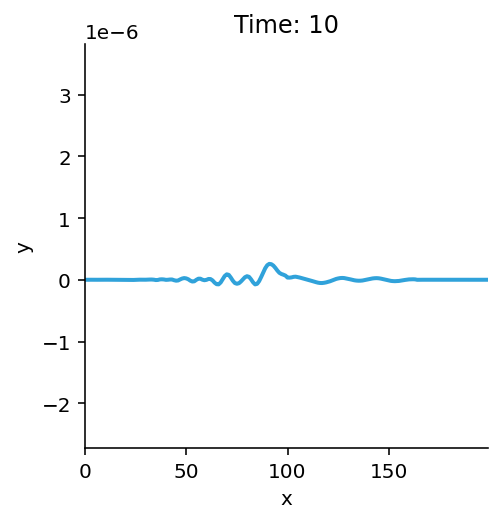
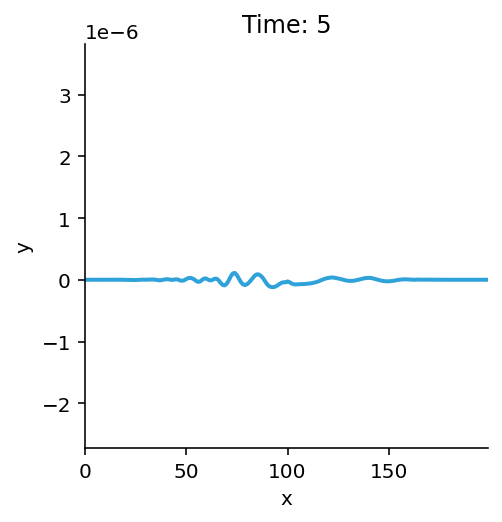
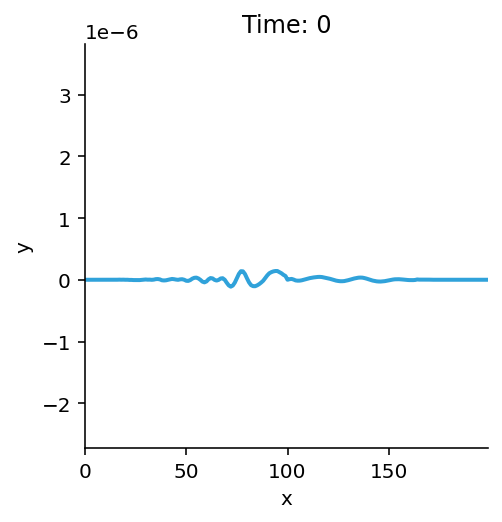

In [28]:
hmap = hv.HoloMap(snaps, kdims='Time')
hmap

## Can we reverse the waves?
We continue propagating from previous steps to see if we can reverse the process exactly

In [29]:
# nsteps = [1,3,5]
# prev_wfld = data.clone()
# orig = data.clone()

# for i in nsteps:
#     for _ in range(i):
#         pspi.forward(False, data, next_wfld)
#         data[:] = next_wfld[:]
#     for _ in range(i):
#         pspi.adjoint(False, prev_wfld, next_wfld)
#         next_wfld[:] = prev_wfld[:]
#     print(np.linalg.norm(prev_wfld[:]-orig[:]))
    

In [30]:
# pspi.dotTest(verbose=True)